In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import os
from matplotlib.transforms import Bbox
from matplotlib.lines import Line2D
import xarray as xr

In [2]:
def cfad(data ,bin, height, h, type, id):
    """
    data: radar data with dimensions (time, height)
    bin: bins along x-axis, e.g. np.linspace(-30,30,num=61) for reflectivity
    height: height bins of the Radar
    h: len(height)
    type: 'ref', 'vel', or 'sw' for reflectivity, Doppler velocity and Spectrum width
    id: naming the figure with an id
    """
    invalid = np.logical_or(data>max(bin), data<min(bin))
    data[invalid] = np.nan
    ### Initalize arrays ###
    frequency = np.zeros((len(bin), h),dtype=int) # data shown
    ref_ave = np.zeros(h+1)
    ref_90 = np.zeros(h+1)
    ref_10 = np.zeros(h+1)
    ref_min = np.zeros(h+1)
    data_trans = np.transpose(data)

    ### Loop over every y bin ###
    for j in range(0, h):
        ### mean and 10th and 90th percentile for reflectivity ###
        if type == "ref":
            ref_ave[j] = np.nanmean(10**(data_trans[j]/10.0))
            ref_10[j] = np.nanpercentile(data_trans[j],10)
            ref_90[j] = np.nanpercentile(data_trans[j],90)
            ref_ave[j] = 10.0*np.log10(ref_ave[j])
            ref_min[j] = np.nanpercentile(data_trans[j],0.01)
        ### mean and 10th and 90th percentile for doppler velocity and spectrum width ###
        if type == "vel" or type == "sw":
            ref_ave[j] = np.nanmean(data_trans[j])
            ref_10[j] = np.nanpercentile(data_trans[j],10)
            ref_90[j] = np.nanpercentile(data_trans[j],90)
        ### loop over every x bin and assign data to each CFAD pixel ###
        for k in range(0,len(bin)-1):
            freq = np.where(np.logical_and(data_trans[j] >= bin[k], data_trans[j] < bin[k+1]))[0]
            frequency[k,j] = len(freq)

    ### Normalized frequency ###
    sum_frequency = np.sum(frequency)
    frequency = frequency/sum_frequency

    ### Minimum and Maximum frequecny for colorbar ###
    min_scale = np.nanmin(list(map(min, frequency)))
    max_scale = np.nanmax(list(map(max, frequency)))

    ### Colorbar parameters ###
    cmap = plt.get_cmap('viridis')
    bounds = np.arange(0,max_scale+0.00001,0.00001)
    colorlist  = [cmap(i) for i in range(cmap.N)]
    cmap = mpl.colors.LinearSegmentedColormap.from_list('Custom cmap', colorlist, cmap.N)
    norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

    ### Plot CFAD ###
    fig, ax = plt.subplots(1,1, figsize=(10,6))
    cf = ax.pcolormesh(bin, height, np.transpose(frequency),cmap=cmap,norm=norm)

    ### Line plots of mean, 10th and 90th percentile ####
    hlim = 205
    #ax.plot(ref_ave[:hlim], height[:hlim], c = 'red',linewidth=2.3)
    #ax.plot(ref_10[:hlim], height[:hlim], ls = "--", c = 'red', linewidth=2.3)
    #ax.plot(ref_90[:hlim], height[:hlim], ls = "dotted", c = 'red',linewidth=2.3)
    

    ### Differences between radar variables ###
    if type == "ref":
        ax.set_xlabel("Reflectivity [dBZ]",fontsize = 15)
        name = "_reflectivity"
        xticks = np.arange(-30,31,10)
        # files = np.savetxt("/glade/u/home/clackner/CAO/Scripts/txt_files/ref_min.txt", ref_min, delimiter = "\t", fmt = "%s")
    if type == "vel":
        ax.set_xlabel("Doppler Velocity [m s$^{-1}$]",fontsize = 15)
        name = "_velocity"
        cbx = 10
        ax.vlines(0,0,10000,linestyles="--",colors="white") # vertical lineat 0 m/s
        xticks = np.round(np.arange(-2.5,1.6,0.5),1)
    if type == "sw":
        ax.set_xlabel("Spectrum Width [m s$^{-1}$]",fontsize = 15)
        name = "_spectrum_width"
        cbx = 10
        xticks = np.round(np.arange(0,1.1,0.1),1)

    ### Labeling ###
    ax.set_ylabel("MSL [km]",fontsize = 15)
    ax.tick_params(axis='both', which='major', labelsize=15)
    ax.set_yticks(np.arange(0,10000,1000))
    ax.set_yticklabels(np.arange(0,10,1),fontsize = 15)
    ax.set_ylim(0,8000)
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticks, fontsize =15)

    ### add colorbar to figure ###
    cbx = int(len(bounds)/10) # skip how many ticks of colorbar
    fig.subplots_adjust(right=0.8)
    cax = fig.add_axes([0.825,0.15,0.0225,0.7])
    cbar = fig.colorbar(cf, cax=cax)
    cbar.set_ticks(bounds[::cbx])
    cbar.set_ticklabels(np.around(bounds[::cbx]*10000, decimals=1))
    cbar.ax.tick_params(labelsize=14)
    cbar.set_label("Normalized Frequency [10$^{-4}$]", fontsize = 15)

    ### Save CFAD ###
    os.makedirs("CFAD", exist_ok = True)
    plt.savefig("CFAD/cfad"+name+id+".png", dpi = 300, bbox_inches='tight')
    plt.show()

In [3]:
# def cfad(data ,bin, height, h, type, id):
#     """
#     data: radar data with dimensions (time, height)
#     bin: bins along x-axis, e.g. np.linspace(-30,30,num=61) for reflectivity
#     height: height bins of the Radar
#     h: len(height)
#     type: 'ref', 'vel', or 'sw' for reflectivity, Doppler velocity and Spectrum width
#     id: naming the figure with an id
#     """
#     invalid = np.logical_or(data>max(bin), data<min(bin))
#     data[invalid] = np.nan
#     ### Initalize arrays ###
#     frequency = np.zeros((len(bin), h),dtype=int) # data shown
#     ref_ave = np.zeros(h+1)
#     ref_90 = np.zeros(h+1)
#     ref_10 = np.zeros(h+1)
#     ref_min = np.zeros(h+1)
#     data_trans = np.transpose(data)

#     ### Loop over every y bin ###
#     for j in range(0, h):
#         ### mean and 10th and 90th percentile for reflectivity ###
#         if type == "ref":
#             ref_ave[j] = np.nanmean(10**(data_trans[j]/10.0))
#             ref_10[j] = np.nanpercentile(data_trans[j],10)
#             ref_90[j] = np.nanpercentile(data_trans[j],90)
#             ref_ave[j] = 10.0*np.log10(ref_ave[j])
#             ref_min[j] = np.nanpercentile(data_trans[j],0.01)
#         ### mean and 10th and 90th percentile for doppler velocity and spectrum width ###
#         if type == "vel" or type == "sw":
#             ref_ave[j] = np.nanmean(data_trans[j])
#             ref_10[j] = np.nanpercentile(data_trans[j],10)
#             ref_90[j] = np.nanpercentile(data_trans[j],90)
#         ### loop over every x bin and assign data to each CFAD pixel ###
#         for k in range(0,len(bin)-1):
#             freq = np.where(np.logical_and(data_trans[j] >= bin[k], data_trans[j] < bin[k+1]))[0]
#             frequency[k,j] = len(freq)

#     ### Normalized frequency ###
#     sum_frequency = np.sum(frequency)
#     frequency = frequency/sum_frequency

#     ### Minimum and Maximum frequecny for colorbar ###
#     min_scale = np.nanmin(list(map(min, frequency)))
#     max_scale = np.nanmax(list(map(max, frequency)))

#     ### Colorbar parameters ###
#     cmap = plt.get_cmap('viridis')
#     bounds = np.arange(0,max_scale+0.00001,0.00001)
#     colorlist  = [cmap(i) for i in range(cmap.N)]
#     cmap = mpl.colors.LinearSegmentedColormap.from_list('Custom cmap', colorlist, cmap.N)
#     norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

#     ### Plot CFAD ###
#     fig, ax = plt.subplots(1,3, figsize=(10,6))
#     ax = ax.flatten()
    
#     for i, v in enumerate(ax):
#         if i == 0: 
#             cf = ax[i].pcolormesh(bin, height, np.transpose(frequency),cmap=cmap,norm=norm)
#             ### Line plots of mean, 10th and 90th percentile ####
#             hlim = 205
#             #ax.plot(ref_ave[:hlim], height[:hlim], c = 'red',linewidth=2.3)
#             #ax.plot(ref_10[:hlim], height[:hlim], ls = "--", c = 'red', linewidth=2.3)
#             #ax.plot(ref_90[:hlim], height[:hlim], ls = "dotted", c = 'red',linewidth=2.3)
            
#             ### Differences between radar variables ###
#             if type == "ref":
#                 ax[i].set_xlabel("Reflectivity [dBZ]",fontsize = 15)
#                 name = "_reflectivity"
#                 xticks = np.arange(-30,31,10)
#                 # files = np.savetxt("/glade/u/home/clackner/CAO/Scripts/txt_files/ref_min.txt", ref_min, delimiter = "\t", fmt = "%s")
#             # if type == "vel":
#             #     ax.set_xlabel("Doppler Velocity [m s$^{-1}$]",fontsize = 15)
#             #     name = "_velocity"
#             #     cbx = 10
#             #     ax.vlines(0,0,10000,linestyles="--",colors="white") # vertical lineat 0 m/s
#             #     xticks = np.round(np.arange(-2.5,1.6,0.5),1)
#             # if type == "sw":
#             #     ax.set_xlabel("Spectrum Width [m s$^{-1}$]",fontsize = 15)
#             #     name = "_spectrum_width"
#             #     cbx = 10
#             #     xticks = np.round(np.arange(0,1.1,0.1),1)

#     ### Labeling ###
#     # ax[i].set_ylabel("MSL [km]",fontsize = 15)
#     ax[i].tick_params(axis='both', which='major', labelsize=15)
#     ax[i].set_yticks(np.arange(0,10000,1000))
#     ax[i].set_yticklabels(np.arange(0,10,1),fontsize = 15)
#     ax[i].set_ylim(0,8000)
#     ax[i].set_xticks(xticks)
#     ax[i].set_xticklabels(xticks, fontsize =15)

#     ### add colorbar to figure ###
#     cbx = int(len(bounds)/10) # skip how many ticks of colorbar
#     fig.subplots_adjust(right=0.8)
#     cax = fig.add_axes([0.825,0.15,0.0225,0.7])
#     cbar = fig.colorbar(cf, cax=cax)
#     cbar.set_ticks(bounds[::cbx])
#     cbar.set_ticklabels(np.around(bounds[::cbx]*10000, decimals=1))
#     cbar.ax.tick_params(labelsize=14)
#     cbar.set_label("Normalized Frequency [10$^{-4}$]", fontsize = 15)

#     ### Save CFAD ###
#     # os.makedirs("CFAD", exist_ok = True)
#     # plt.savefig("CFAD/cfad"+name+id+".png", dpi = 300, bbox_inches='tight')
#     plt.show()

In [7]:
path = "/glade/work/noteng/masters-research/data/anx-data/otengn1/240475/KAZR/anxarsclkazr1kolliasM1/anxarsclkazr1kolliasM1.c1.20200313.000000.nc"
ds = xr.open_dataset(path)
ds = ds.sel(time=slice('2020-03-13 08:12:28', '2020-03-13 09:06:36'))   
reflectivity = ds['reflectivity_best_estimate']
doppler_velocity = ds['mean_doppler_velocity']
spectral_width = ds['spectral_width']

/glade/work/noteng/conda-envs/dynamics_class/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: Mean of empty slice
/glade/work/noteng/conda-envs/dynamics_class/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1376: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation


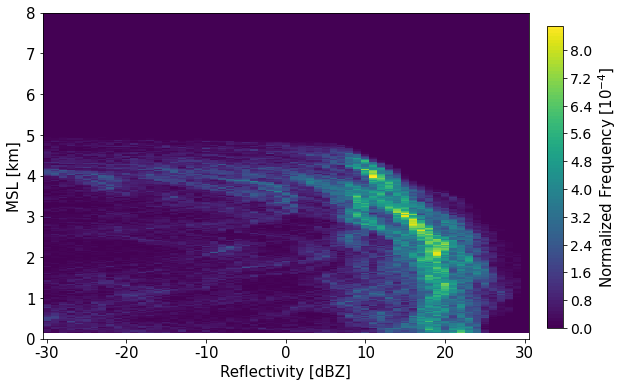

In [11]:
cfad(reflectivity.data, np.linspace(-30, 30, 61), reflectivity['height'], len(reflectivity['height']), 'ref', '3')

In [19]:
one = reflectivity.sel(time=slice('2020-03-13 10:00:12', '2020-03-13 10:11:56'))
two = reflectivity.sel(time=slice('2020-03-13 16:29:40', '2020-03-13 16:38:20')) #17
three = reflectivity.sel(time=slice('2020-03-13 23:38:56', '2020-03-14 00:16:28')) #29
four = reflectivity.sel(time=slice('2020-03-14 00:13:24', '2020-03-14 00:30:44')) # 30

In [20]:
ref = xr.concat([one, two, three, four], dim='time')
ref

<xarray.DataArray 'reflectivity_best_estimate' (time: 624, height: 596)>
array([[-30.098259 , -28.851479 , -32.21338  , ...,         nan,
                nan,         nan],
       [-32.80472  , -37.673332 , -34.05925  , ...,         nan,
                nan,         nan],
       [-29.934044 , -34.936462 , -32.292442 , ...,         nan,
                nan,         nan],
       ...,
       [  3.4588475,   3.9058535,   4.0015354, ...,         nan,
                nan,         nan],
       [  3.1425862,   3.3250277,   3.4024677, ...,         nan,
                nan,         nan],
       [  2.9388433,   3.0422137,   3.7977924, ...,         nan,
                nan,         nan]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2020-03-13T10:00:12 ... 2020-03-13T23:59:56
  * height   (height) float32 160.0 190.0 220.0 ... 1.798e+04 1.801e+04
Attributes:
    long_name:            Best-estimate reflectivity
    units:                dBZ
    ancillary_variables:  qc_reflectivity_best_estimate
    valid_min:            -90.0
    valid_max:            50.0
    resolution:           0.001
    comment:              Contains data from best radar operating mode (see r...

/glade/work/noteng/conda-envs/dynamics_class/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: Mean of empty slice
/glade/work/noteng/conda-envs/dynamics_class/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1376: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation


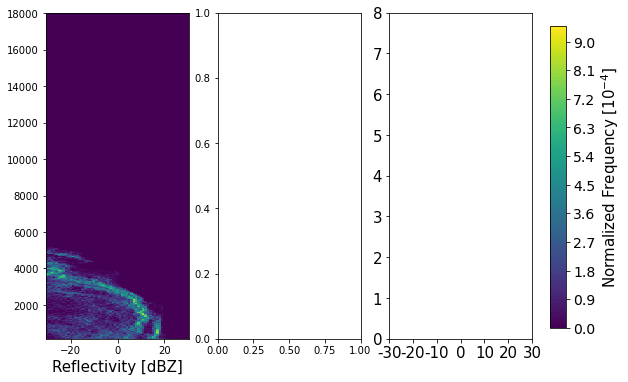

In [21]:
cfad(data=ref.data, 
     bin=np.linspace(-30,30,num=61),
     height=ref['height'], 
     h=len(ref['height']),
     type='ref',
     id='1')

In [1]:
# Open the dataset
path = "/glade/work/noteng/masters-research/data/anx-data/otengn1/240475/KAZR/anxarsclkazr1kolliasM1/anxarsclkazr1kolliasM1.c1.20200313.000000.nc"
ds = xr.open_dataset(path)

ds

NameError: name 'xr' is not defined

/glade/work/noteng/conda-envs/dynamics_class/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: Mean of empty slice
/glade/work/noteng/conda-envs/dynamics_class/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1376: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation


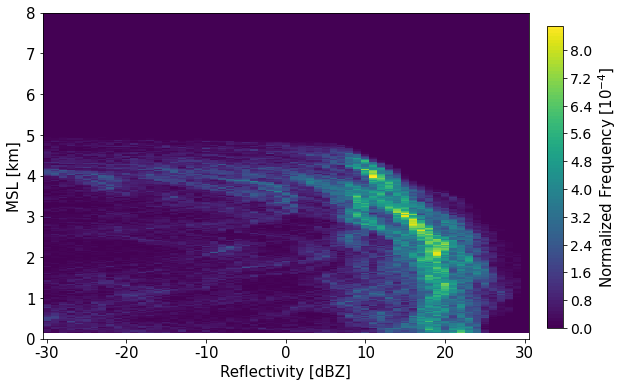

In [16]:
cfad(data=reflectivity.data, 
     bin=np.linspace(-30,30,num=61),
     height=reflectivity['height'], 
     h=len(reflectivity['height']),
     type='ref',
     id='1')